In [1]:
# Generate LDA histograms

In [2]:
!pwd
!date

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureEdgesExt
Mon Jun 27 21:31:16 PDT 2022


In [3]:
import os
import sys
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from sklearn.decomposition import PCA
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
config = general.load_config_file(path_config)
control = controller.Controller(config)
device = io.LocalStagingIO(control)
df = device.load_step_manifest("preprocessing")
print(df.shape, control.get_staging())

(202847, 1290) /allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [5]:
space = shapespace.ShapeSpace(control)
space.execute(df)

In [6]:
# local_staging_variance_edges is generated by using the output dataframe from the
# mapping process to filter out not matched cells from the full dataset.
dsname = "edges"
path_cvapipe = Path(control.get_staging()).parent
datasets = {
    dsname: {
        "control": f"{path_cvapipe}/local_staging_variance_edges",
        "perturbed": f"{path_cvapipe}/local_staging_edge_cells_midpoint_expanded"
    }}

In [7]:
smapper = shapespace.ShapeSpaceMapper(space, output_folder="./")
smapper.use_full_base_dataset()
smapper.set_make_plots_off()
smapper.set_distance_threshold(1e10)
smapper.map(datasets)
df_map = smapper.result
df_map.head()

	edges loaded. (5169, 1255)


NUC_MEM_PC1  NUC_MEM_PC2  NUC_MEM_PC3  \
dataset structure_name CellId                                          
base    AAVS1          466245    -0.268392    -0.829342     0.047623   
                       466246    -0.243572    -0.607768     0.631536   
                       466248    -0.402700    -0.944572    -0.832112   
                       466252     0.204445     0.848568     0.504295   
                       466254    -0.560492     0.529491     0.330510   

                               NUC_MEM_PC4  NUC_MEM_PC5  NUC_MEM_PC6  \
dataset structure_name CellId                                          
base    AAVS1          466245     1.605686     2.121168     4.532402   
                       466246     0.183432    -0.023279     0.018517   
                       466248    -0.943582     1.107919     0.192332   
                       466252     1.485295     1.869869    -1.348345   
                       466254    -0.276561    -0.058453    -0.889612   

                               NUC_MEM_PC7  NUC_MEM_PC8  Dist  SelfDist  \
dataset structure_name CellId                                             
base    AAVS1          466245    -1.457945    -1.057154   NaN       NaN   
                       466246    -0.563475     0.252653   NaN       NaN   
                       466248     1.015603     2.536338   NaN       NaN   
                       466252    -0.242527     0.777065   NaN       NaN   
                       466254     1.469526    -0.531350   NaN       NaN   

                               NNCellId  Match  edges  
dataset structure_name CellId                          
base    AAVS1          466245        -1  False  False  
                       466246        -1  False  False  
                       466248        -1  False   True  
                       466252        -1  False  False  
                       466254        -1  False  False

### Control and Device for each shape matched dataset (control and perturbed)

In [8]:
importlib.reload(io)
importlib.reload(common)

<module 'common' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureEdgesExt/../tools/common.py'>

In [9]:
dsmanagers = common.setup_cvapipe_for_matched_dataset(config, datasets[dsname])

### Load representations and compute PCA

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

Data shape: (868, 532610) (uint8, 440.9Mb)
0 -0.8551586
1 0.69448155


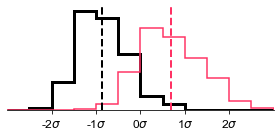

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/385 [00:00<?, ?it/s]

Data shape: (704, 532610) (uint8, 357.6Mb)
0 -0.42235073
1 0.34994772


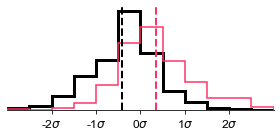

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

Data shape: (336, 532610) (uint8, 170.7Mb)
0 -0.41160324
1 0.38321677


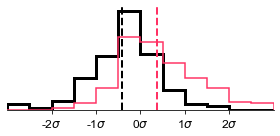

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Data shape: (98, 532610) (uint8, 49.8Mb)
0 -0.70899
1 0.6533829


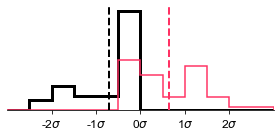

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

Data shape: (583, 532610) (uint8, 296.1Mb)
0 -0.69674647
1 0.5766178


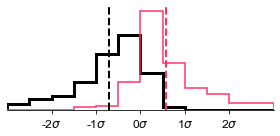

  0%|          | 0/214 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Data shape: (460, 532610) (uint8, 233.7Mb)
0 -0.65364945
1 0.5686219


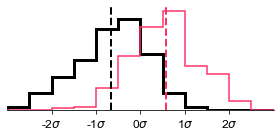

  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

Data shape: (630, 532610) (uint8, 320.0Mb)
0 -0.7242826
1 0.59449786


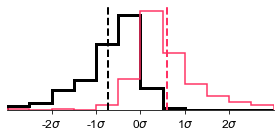

In [10]:
for gene in ["TUBA1B", "LAMP1", "ST6GAL1", "ACTB", "MYH10", "CTNNB1", "ACTN1"]:

    df_gene = df_map.loc[(dsname,gene)]

    CellIds_pt = df_gene.index.values
    CellIds_ct = df_gene.NNCellId.unique()

    rloader_ct = common.RepsSharedMemoryLoader(dsmanagers["control"]["control"])
    rloader_pt = common.RepsSharedMemoryLoader(dsmanagers["perturbed"]["control"])
    reps_ct = rloader_ct.load(CellIds_ct).astype(np.uint8)
    reps_pt = rloader_pt.load(CellIds_pt).astype(np.uint8)
    
    reps = np.concatenate([reps_ct, reps_pt], axis=0)
    vsize = int(sys.getsizeof(reps)) / float(1 << 20)
    print(f"Data shape: {reps.shape} ({reps.dtype}, {vsize:.1f}Mb)")
    
    npcs = np.min([32, reps.shape[0]-1])
    pca = PCA(npcs, svd_solver="full")
    pca = pca.fit(reps)
    axes = pca.transform(reps)
    axes = pd.DataFrame(axes, columns=[f"PC{i}" for i in range(1, 1+npcs)])
    
    groups = np.array([0]*len(CellIds_ct) + [1]*len(CellIds_pt))
    stds = axes.std(axis=0)
    axes /= stds
    axes, pca = common.sort_pcs(axes, groups, pca)
    axes["Dataset"] = groups
    axes["CellId"] = CellIds_ct.tolist() + CellIds_pt.tolist()
    axes = axes.set_index(["Dataset", "CellId"])
    axes.head()
    
    lda = common.SimpleBinaryLDA()
    lda = lda.sfit(axes.values, groups)
    lda_values = lda.transform(axes.values).flatten()
    axes["LDA"] = lda_values

    # Histograms
    xmin, xmax = -3, 3
    edges = np.linspace(xmin, xmax, 1+int((xmax-xmin)/0.5))
    fig, ax = plt.subplots(1,1, figsize=(4.0, 2))
    for color, (g, df_group) in zip(["black","#FF3264"], axes.groupby("Dataset")):
        lw = 3 if g == 0 else 1.5
        ax.hist(df_group.LDA, bins=edges, histtype="step", color=color, density=True, lw=lw)
        ax.axvline(x=df_group.LDA.mean(), color=color, lw=2, linestyle="--", zorder=1e10)
        print(g, df_group.LDA.mean())
    ax.set_xlim(xmin, xmax)
    for pos in ["top", "right", "left"]:
        ax.spines[pos].set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    sigmas = np.linspace(-2, 2, 5)
    ax.set_xticks(sigmas, [f"{int(s)}$\sigma$" for s in sigmas])
    ax.tick_params(axis="x", which='major', labelsize=12)
    plt.tight_layout()
    plt.savefig(f"FigureEdgesExt3_{gene}_lda_hist.pdf")
    plt.show()

In [11]:
common.now("complete")

complete 2022-06-27 21:40:09
